C:\Users\Owner\AppData\Local\Temp\ipykernel_14636\1094219759.py:89: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, w, shading='interp')


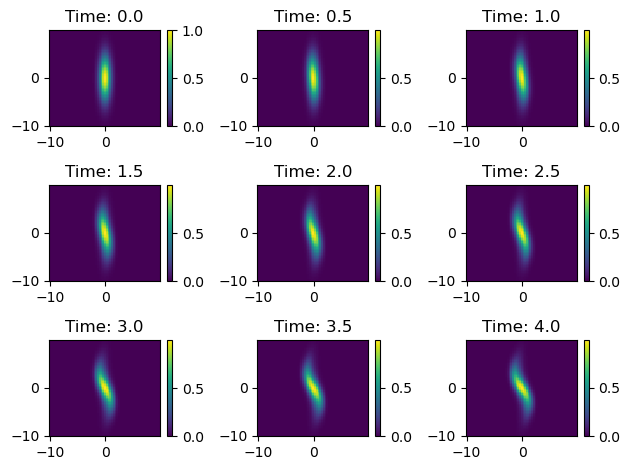

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp
from scipy.sparse import spdiags, csr_matrix
from scipy.linalg import solve, lu, solve_triangular
from scipy.sparse.linalg import bicgstab, gmres
import time
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#Define tspan
tspan = np.arange(0, 4 + 0.5, 0.5) # Time stepping from t = 0 to 4 in 0.5 increments
nu = 0.001
Lx, Ly = 20, 20 # Range is from - 10 to 10 on both x and y
nx, ny = 64, 64 # Domain chopped into 64 points
N = nx * ny

x2 = np.linspace(-Lx/2, Lx/2, nx + 1) # Setting up range from -10 to 10 in 64 + 1 points
x = x2[:nx] # Chopping off last point
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]

X, Y = np.meshgrid(x, y)
# regular initial condition
w = 1 * np.exp(-X**2 - (Y**2)/20) + 1j * np.zeros((nx, ny)) 

# positive and negative charged 
#w = 1 * (np.exp(-(X+2)**2 - ((Y+2)**2)/20) - np.exp(-(X-2)**2 - ((Y-2)**2)/20)) + 1j * np.zeros((nx, ny)) 

# two of same charge
#w = 1 * (np.exp(-(X+2)**2 - (Y**2)/20) + np.exp(-(X-2)**2 - (Y**2)/20)) + 1j * np.zeros((nx, ny)) 

# two pairs of opposite charge
#w = 1 * (
#    np.exp(-(X+2)**2 - ((Y+2)**2)/20)
#    - np.exp(-(X-2)**2 - ((Y+2)**2)/20)
#
#    + np.exp(-(X+2)**2 - ((Y-2)**2)/20)
#    - np.exp(-(X-2)**2 - ((Y-2)**2)/20)
#) + 1j * np.zeros((nx, ny))

# vorticity field generator
#num_vortices = 10
#w = np.zeros((nx, ny), dtype = complex)
#for _ in range(num_vortices):
#    # Random position within the domain
#    x_center = np.random.uniform(-Lx/2, Lx/2)
#    y_center = np.random.uniform(-Ly/2, Ly/2)
#    # Random amplitude (positive or negative)
#    amplitude = np.random.choice([-1, 1]) * np.random.uniform(0.5, 1.5)
#    # Add Gaussian vortex
#    w += amplitude * np.exp(-(X - x_center)**2 - ((Y- y_center)**2)/20) + 1j * np.zeros((nx, ny))


# Define spectral K values to undo shift that the fft command does
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6

KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

def spc_rhs(t, wt2, nx, ny, N, KX, KY, K, nu):
    wtc = wt2[0:N] + 1j*wt2[N:]
    wt = wtc.reshape((nx,ny))
    psit = -wt / K
    psix = np.real(ifft2(1j * KX * psit))
    psiy = np.real(ifft2(1j * KY * psit))
    wx = np.real(ifft2(1j * KX * wt))
    wy = np.real(ifft2(1j * KY * wt))
    rhs = (-nu * K * wt + fft2(wx * psiy - wy * psix)).reshape(N)
    return np.hstack([np.real(rhs), np.imag(rhs)])

wt0 = np.hstack([np.real(fft2(w).reshape(N)),np.imag(fft2(w).reshape(N))])

start_time = time.time()
wtsol = solve_ivp(spc_rhs, (0, 4), wt0, t_eval=tspan, method = 'RK45', args = (nx, ny, N, KX, KY, K, nu))
end_time = time.time()

fft_time = end_time - start_time

A1 = []
for j, t in enumerate(wtsol.t):
    w = np.real(ifft2(wtsol.y[:N,j].reshape((nx, ny))))
    A1.append(w)
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [128]:
# FFT Animation Code

fig, ax = plt.subplots()
c = ax.pcolor(X, Y, A1[-1], shading='auto', cmap='viridis')
fig.colorbar(c, ax=ax)
time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, color='white', fontsize=12)

# Define the update function for the animation
def update(frame):
    c.set_array(A1[frame].flatten())
    time_text.set_text(f'Time: {tspan[frame]:.2f}')
    return c, time_text

# Create the animation
ani = FuncAnimation(fig, update, frames=len(A1), interval=100, blit=False)

plt.close(fig)
HTML(ani.to_jshtml())
#ani.save('fft_random_vortices.gif', writer = 'pillow', fps = 10)

In [129]:
# Now including our matrices from homework 4
m = nx
d = Lx/nx

e0 = np.zeros((N,1))
e1 = np.ones((N,1))
e2 = np.copy(e1)
e4 = np.copy(e0)

for j in range(1, m+1):
    e2[m*j-1] = 0  
    e4[m*j-1] = 1  

e3 = np.zeros_like(e2)
e3[1:N] = e2[0:N-1]
e3[0] = e2[N-1]

e5 = np.zeros_like(e4)
e5[1:N] = e4[0:N-1]
e5[0] = e4[N-1]

diagonals = [e1.flatten(), e1.flatten(), e5.flatten(), 
             e2.flatten(), -4 * e1.flatten(), e3.flatten(), 
             e4.flatten(), e1.flatten(), e1.flatten()]
offsets = [-(N-m), -m, -m+1, -1, 0, 1, m-1, m, (N-m)]

A = spdiags(diagonals, offsets, N, N).toarray()

A /= d**2

diagonals_B = [e1.flatten(), -1 * e1.flatten(), e1.flatten(), -1 * e1.flatten()]
offsets_B = [-(N-m), -m, m, (N-m)]

B = spdiags(diagonals_B, offsets_B, N, N).toarray()
B /= 2*d

diagonals_C = [e1.flatten(), -e1.flatten(), e1.flatten(), -e1.flatten()]
offsets_C = [-(m-1), -1, 1, (m-1)]
C = spdiags(diagonals_C, offsets_C,m,m).toarray()
C /= 2*d

I = np.eye(m)
C = np.kron(I,C)

C:\Users\Owner\AppData\Local\Temp\ipykernel_14636\1488183531.py:21: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, w, shading='interp')


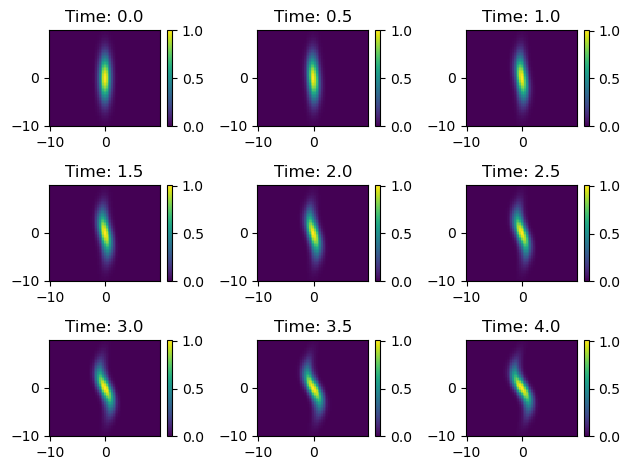

In [130]:
# Solving the problem using our A B and C matrices now
A[0,0] = 2
w = (1 * np.exp(-X**2 - (Y**2)/20)).flatten()

def spc_rhs(t, w, nu, A, B, C):
    psi = solve(A, w)
    rhs = -(nu * A.dot(w) - (B.dot(psi)*C.dot(w) - C.dot(psi)*B.dot(w)))
    return rhs

start_time = time.time()
wtsol = solve_ivp(spc_rhs, (0, 4), w, t_eval=tspan, method = 'RK45', args = (nu, A, B, C))
end_time = time.time()

Ab_time = end_time - start_time

A2 = []
for j, t in enumerate(wtsol.t):
    w = wtsol.y[:N,j].reshape((nx,ny))
    A2.append(w)
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_14636\930116652.py:24: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, w, shading='interp')


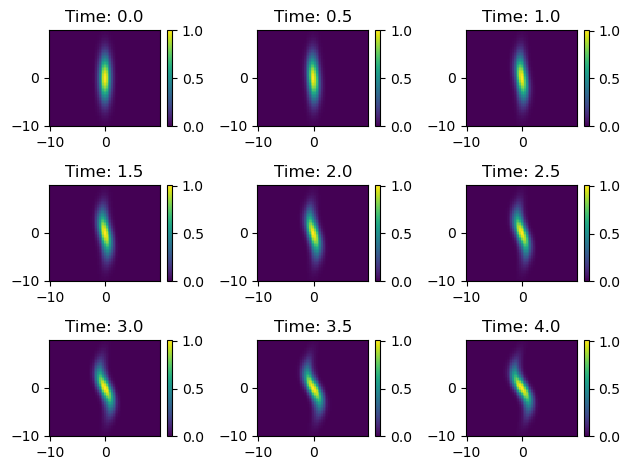

In [131]:
# Now solving using LU
w = (1 * np.exp(-X**2 - (Y**2)/20)).flatten()

P, L, U = lu(A)

def spc_rhs(t, w, nu, A, B, C, P, L):
    Pw = np.dot(P, w)
    foo = solve_triangular(L, Pw, lower=True)
    psi = solve_triangular(U, foo)
    rhs = -(nu * A.dot(w) - (B.dot(psi)*C.dot(w) - C.dot(psi)*B.dot(w)))
    return rhs

start_time = time.time()
wtsol = solve_ivp(spc_rhs, (0, 4), w, t_eval=tspan, method = 'RK45', args = (nu, A, B, C, P, L))
end_time = time.time()

LU_time = end_time - start_time

A3 = []
for j, t in enumerate(wtsol.t):
    w = wtsol.y[:N,j].reshape((nx,ny))
    A3.append(w)
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_14636\2656020126.py:28: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, w, shading='interp')


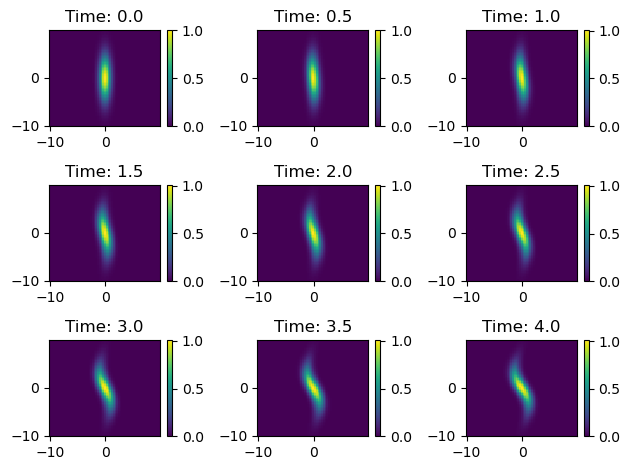

In [132]:
# Solve using BICGSTAB
w = (1 * np.exp(-X**2 - (Y**2)/20)).flatten()
A = csr_matrix(A)

residuals_bic = []
def bic_callback(residual_norm):
    residuals_bic.append(residual_norm)

def spc_rhs(t, w, nu, A, B, C):
    psi, exitcode = bicgstab(A, w, atol = 1e-4, callback = bic_callback)
    if exitcode != 0:
        raise ValueError(f"BiCGSTAB failed to converge. Exit code: {exitcode}")

    rhs = -(nu * A.dot(w) - (B.dot(psi) * C.dot(w) - C.dot(psi) * B.dot(w)))
    return rhs

start_time = time.time()
wtsol = solve_ivp(spc_rhs, (0, 4), w, t_eval=tspan, method = 'RK45', args = (nu, A, B, C))
end_time = time.time()

bic_time = end_time - start_time

ABic= []
for j, t in enumerate(wtsol.t):
    w = wtsol.y[:N,j].reshape((nx,ny))
    ABic.append(w)
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_14636\1206725461.py:26: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, w, shading='interp')


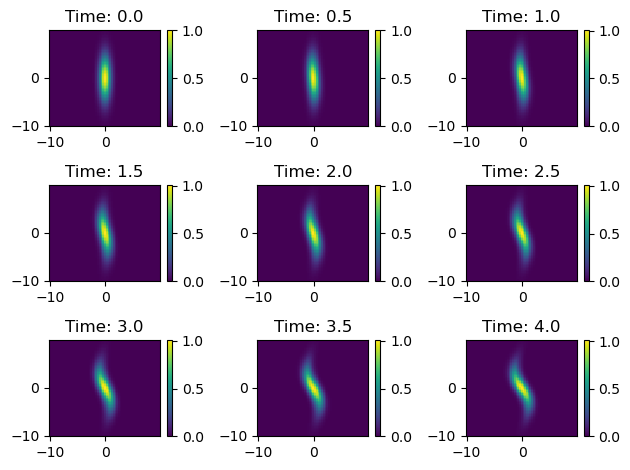

In [133]:
w = (1 * np.exp(-X**2 - (Y**2)/20)).flatten()

residuals_gm = []
def gm_callback(residual_norm):
    residuals_gm.append(residual_norm)

def spc_rhs(t, w, nu, A, B, C):
    psi, exitcode = gmres(A, w, tol = 1e-4, callback = gm_callback)
    if exitcode != 0:
        raise ValueError(f"GMRES failed to converge. Exit code: {exitcode}")
    
    rhs = -(nu * A.dot(w) - (B.dot(psi) * C.dot(w) - C.dot(psi) * B.dot(w)))
    return rhs

start_time = time.time()    
wtsol = solve_ivp(spc_rhs, (0, 4), w, t_eval=tspan, method = 'RK45', args = (nu, A, B, C))
end_time = time.time()

gm_time = end_time - start_time

AGM= []
for j, t in enumerate(wtsol.t):
    w = wtsol.y[:N,j].reshape((nx,ny))
    AGM.append(w)
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()
    

In [134]:
#times = [fft_time, Ab_time, LU_time, bic_time, gm_time]
print("FFT solve time:", fft_time)
print("A/b solve time:", Ab_time)
print("LU solve time:", LU_time)
print("BICGSTAB solve time:", bic_time)
print("GMRES solve time:", gm_time)
print("BICGSTAB iteration count:", len(residuals_bic))
print("GMRES iteration count:", len(residuals_gm))

FFT solve time: 0.026830673217773438
A/b solve time: 12.237892150878906
LU solve time: 1.2067131996154785
BICGSTAB solve time: 2.1428310871124268
GMRES solve time: 28.091329097747803
BICGSTAB iteration count: 9980
GMRES iteration count: 103175
